# Faces in the Wild with GCN Semantic Segmentation

This code snippet runs the gcn semantic segmentation network over the webcam.   
*Eurecat 2019 - Rafael Redondo*

In [0]:
# Make sure your network has been trained with this architectural parameters
target_size = 256
num_classes = 7
num_levels = 3

# I/O
checkpoint = "./gcn-epoch_0480.pth"

# Colorize your labeled classes
label_colors = [
    (0, 0, 0),
    (0, 255, 0),
    (0, 0, 255),
    (255, 255, 0),
    (255, 0, 0),
    (255, 0, 255),
    (0, 255, 255)]

In [2]:
# Prepare Drive by following the instructions
from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Go to Drive contents
cd drive/My\ Drive/ELFW

/content/drive/My Drive/ELFW


In [4]:
# Import
import torch
from torch.autograd import Variable
from torchvision.transforms import ToTensor, Normalize
import torch.nn.functional as F
from gcnX import FCN
from PIL import Image
import numpy as np

# Model loading (Resnet may take a while to download)
model = torch.nn.DataParallel(FCN(num_classes, num_levels))
model.load_state_dict(torch.load(checkpoint))
model.cuda()
model.eval()
;

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 91888532.12it/s]


''

In [0]:
# Google snippet: using a webcam to capture images for processing on the runtime.
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

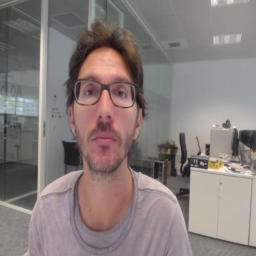

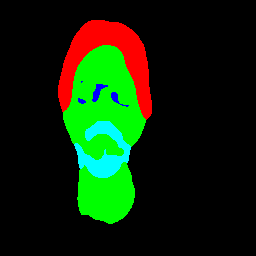

In [15]:
#from IPython.display import Image
from PIL import Image
from google.colab.patches import cv2_imshow
import numpy as np

try:

  filename = take_photo()
  
  # Pass forward
  with torch.no_grad():
    
    #print('Saved to {}'.format(filename))

    image = Image.open('photo.jpg').convert("RGB")
    image = image.resize((target_size, target_size), Image.BILINEAR)
    img = ToTensor()(image)
    img = Normalize([.485, .456, .406], [.229, .224, .225])(img)
    img = Variable(img).cuda().unsqueeze(0)
    scores = model(img)  # first image in batch
    label_probs = F.log_softmax(scores[0], dim=0).cpu().detach().numpy()

    # Composite
    rgb = np.zeros((target_size, target_size, 3))
    labels = np.argmax(label_probs, axis=0)

    for l in range(len(label_probs)):
        indexes = labels == l
        for c in range(3):
            rgb[:, :, c][indexes] = label_colors[l][c]

    result = Image.fromarray(rgb.astype('uint8'))

    # Show the image which was just taken.
    #display(Image(filename))
    cv2_imshow(np.flip(np.array(image),2))
    cv2_imshow(rgb.astype('uint8'))
    
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))